### 9η Εργαστηριακή Άσκηση 

##### Ονοματεπώνυμο: Αλεξανδρόπουλος Σταμάτης
##### Αριθμός Μητρώου: 03117060


###### Παραδοτέο 1 

Σε ένα καινούργιο jupyter notebook, χρησιμοποιήστε την μέθοδο της προσομοιωμένης ανόπτησης για την συνάρτηση:

$$ V(x) = \frac{13}{90} x^4 - \frac{3}{10} x^3 - \frac{101}{45} x^2 \frac{13}{15}x + 4$$

Α) Τρέξτε τον αλγόριθμο `200` φορές και υπολογίστε το ποσοστό των πειραμάτων στα οποία 
ο αλγόριθμος βρήκε το ολικό ελάχιστο και το ποσοστό στο οποίο βρήκε κάποιο τοπικό ελάχιστο
(με ακρίβεια 0.05)

Β) Τρέχτε τον αλγόριθμο `200` φορές για τιμές του `cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]` και εκτιμήστε για κάθε τιμή του την πιθανότητα ο αλγόριθμος να υπολογίσει το ολικό ελάχιστο. 
Κάντε διάγραμμα των τιμών του `cool_factor` και της πιθανότητας εύρεση του ολικού ελάχιστου.


##### Λύση

α) Πρώτα απεικονίζουμε παρακάτω την συνάρτηση προκειμένου να βρούμε το ολικό ελάχιστο για να κάνουμε την σύγκριση.Έπειτα με τη βοήθεια του simulated annealing θα υπολογίσουμε το ποσοστό των φορών που έχουμε το ολικό ελάχιστο.


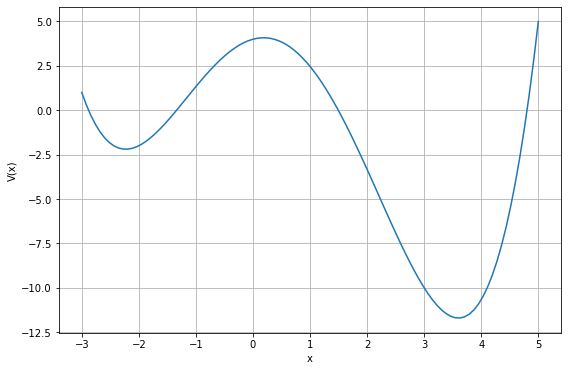

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2017)  # for reproducibility

%matplotlib inline

def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -3/10, -101/45, 13/15, 4), x)

x = np.linspace(-3, 5, 100)

plt.figure(figsize = (9, 6))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()

In [2]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

In [3]:
check = 0
for i in range( 200 ):
    x = sim_anneal( V, -3, 5 )
    if abs( x - 3.6 ) < 1e-1:
        check += 1

perc = check / 2
print("Times we hit global optimum: %.5f"  % perc )
print("Times we hit some local optimum: %.5f" % ( 100 - perc ))

Times we hit global optimum: 82.50000
Times we hit some local optimum: 17.50000


β) Όσον αφορά το δευτερο ζητούμενο έχουμε:

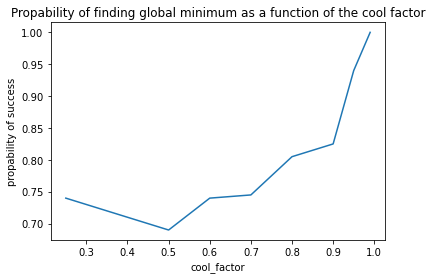

In [4]:
props = []
cool_factor = [ 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99 ]

for factor in cool_factor:
    valid = 0
    for i in range( 200 ):
        x = sim_anneal( V, -3, 5, T=2.0, T_min=2**(-12), cool_factor= factor )
        if abs( x - 3.6 ) < 0.1:
            valid += 1
    props.append( valid / 200 )

plt.title("Propability of finding global minimum as a function of the cool factor")
plt.xlabel("cool_factor")
plt.ylabel("propability of success")
plt.plot( cool_factor, props )
plt.show()
    

### Παραδοτέο 2

Ο κώδικας της εκφώνησης είναι:


In [5]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())

def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.90
cool_schedule = 100

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      60%
Initial distance:	60608 km
Optimal distance:	24177 km


α) Όταν μεταβάλουμε το cool-factor σε 0.9 από 0.95 πετυχαίνουμε τιμή της αντικειμενικής συνάρτησης 22681km, δηλαδή 63%, σε αντίθεση με την προηγούμενη τιμή όπου είχαμε βελτίωση 60%.

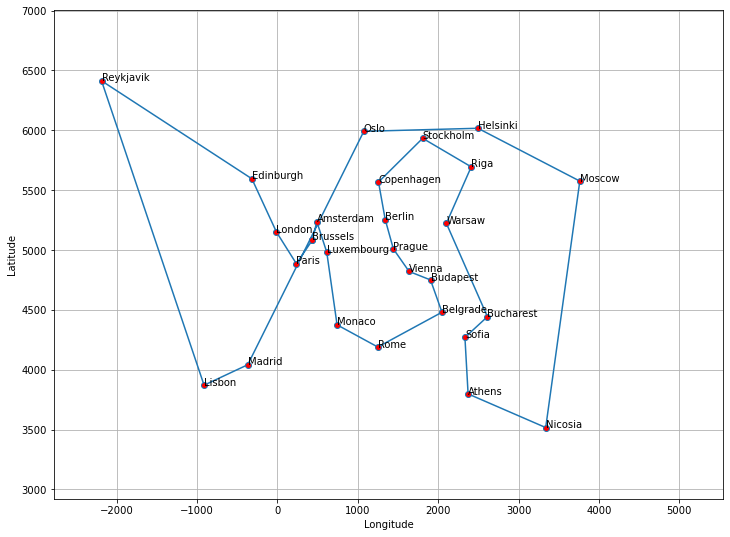

In [7]:
plt.figure(figsize=(12, 9))  # increase image size

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city])
#                  withdash = True,
#                  dashdirection = 1,
#                  dashlength = 30,
#                  rotation = 0,
#                  dashrotation = 20,
#                  dashpush = 10
plt.show()

β) Ο κώδικας με αλλαγμένο url για τις πόλεις  και το διάγραμμα της εξέλιξης της διαδρομής είναι:

In [8]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())

def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.90
cool_schedule = 100

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      68%
Initial distance:	100118 km
Optimal distance:	32078 km


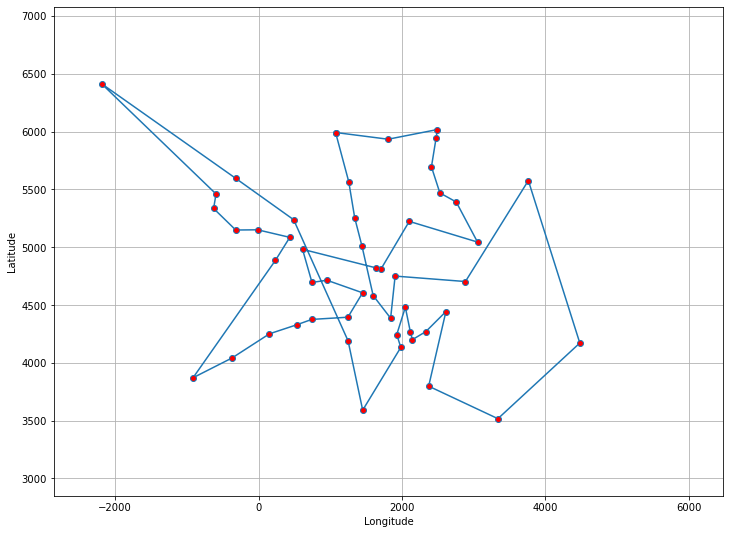

In [9]:
plt.figure(figsize=(12, 9))  # increase image size

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
plt.show()

γ)1. Η πρώτη πόλη μπορεί να εμφανιστεί σε 35 διαφορετικές θέσεις. Aπό τη στιγμή που διαλέξουμε μια θέση για την πρώτη πόλη η δεύτερη έχει 34 πιθανές θέσεις κοκ. Από την πολλαπλασιαστική αρχή λαμβάνουμε ότι συνολικά έχουμε 35*34*...*1 = 35! πιθανές μεταθέσεις για 35 πόλεις.

2. Χρησιμοποιήσουμε καθαρή bruteforce, δοκιμάζοντας δηλαδή όλες τις μεταθέσεις και να επιλέξουμε την καλύτερη, θα χρειαστούμε 35! μsec > 10^33 sec το οποίο είναι παραπάνω από $3 * 10^{26}$ χρόνια. Ωστόσο, αν χρησιμοποιήσουμε δυναμικό προγραμματισμό, μπορούμε να βελτιώσουμε τον αλγόριθμο σε πολυπλοκότητα $O(n^2 * 2^n)$ ο οποίος θα βγάλει αποτέλεσμα σε συντομότερο χρονικό διάστημα από την εξαντλητική αναζήτηση.